In [1]:
# Importing required libraries 
# Keras
from keras.models import model_from_json

# Other  
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pickle
import wave
import IPython.display as ipd  # To play sound in the notebook
import python_speech_features as ps
import pyaudio
import math
import datetime
from concurrent.futures import ThreadPoolExecutor
import time
import struct

In [2]:
class emotionAnalizer():
    def __init__(self):
        super().__init__()
        self.alive = True
        self.extractMellalive = False
        #inputAudioに必要な初期化
        self.CHUNK=1024
        self.RATE = 44100
        self.block = 100
        self.wave = np.empty((self.block,1024),int)
        self.audio = pyaudio.PyAudio()
        self.stream=self.audio.open(format = pyaudio.paInt16,
            channels = 1,
            rate = self.RATE,
            frames_per_buffer = self.CHUNK,
            input = True,
            output=True)
        #detectAudioに必要な初期化
        self.spaceleng = 10
        self.voiceleng = 20
        self.sokuonleng = 3
        self.winlen = 0.08
        self.winstep = 0.016
        self.nfilt = 40 #周波数の分解能
        self.addr = 0 #声を検出するアドレスを指定(どこのアドレスで声の検出を行うか指定)
        self.ave = 0
        self.preave = 0
        self.diff = 0
        self.silent = 0
        self.voice  = 0
        self.standby = -1
        self.isVoice = 0
        self.voiceOnWave = np.empty((0,2,2), int)
        #extractMellに必要な初期化
        self.pastVoiceOnWaveLeng = 0
        self.lastwaddr = 0
        self.features = np.zeros((0, 300, self.nfilt, 3))
        self.eps = 1e-5
        #emotionRecognitionに必要な初期化
        self.pastFeaturesLeng = 0
        self.emotionResult = np.zeros((0,14))
        # loading json and model architecture 
        json_file = open('model_json.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.loaded_model = model_from_json(loaded_model_json)
        # load weights into new model
        self.loaded_model.load_weights("saved_models/Emotion_Model.h5")
        print("Loaded model from disk")

    def inputAudio(self):
        with ThreadPoolExecutor(max_workers=8) as executor:
            while self.alive:
                #time.sleep(0.001)
                ret = self.stream.read(self.CHUNK, exception_on_overflow = False)
                self.stream.write(ret)
                if self.addr % self.block==0:
                    self.wave = np.append(self.wave, np.empty((self.block,1024),int),0)
                self.wave[self.addr] = np.expand_dims(np.frombuffer(ret, dtype="int16"),0)
                self.detectVoice()
                self.extractMell()
                if self.features.shape[0] > self.pastFeaturesLeng:
                    self.pastFeaturesLeng = self.features.shape[0]
                    executor.submit(self.emotionRecognition, self.voiceOnWave[-1,0,0])
                self.addr += 1
    
    def detectVoice(self):
        #print("detectVoice start")
        self.preave = self.ave
        self.ave = np.mean(np.abs(self.wave[self.addr]))
        self.diff = self.ave - self.preave
        #声の部分か判定する。
        if np.abs(self.diff) > 100:
            self.silent = 0
            self.voice  = self.sokuonleng
        else:
            self.silent += 1
            self.voice  -= 1 if self.voice > 0 else 0
        #発話していないなら
        if self.isVoice == 0:
            if self.standby == -1:
                #スタンバイでない時、音を検知したら、スタンバイする(その時の時間を覚えておく)。
                if self.voice == self.sokuonleng:
                    self.standby = self.addr - 1 #発声する瞬間も大事な特微量なので、現在のアドレスより1コマ過去のものから判定開始
            else:
                if self.addr-self.standby >= self.voiceleng:
                    #voiceleng以上発話していれば、isRecをアクティブに。
                    if self.voice != 0:
                        print("Record start{}".format(self.standby, self.addr))
                        self.isVoice = 1
                        self.voiceOnWave = np.append(self.voiceOnWave, np.zeros((1,2,2), int),0)
                        self.voiceOnWave[-1,0,0] = self.standby
                    #voicelengより短い発話だったら、スタンバイ解除
                    elif self.voice == 0:
                        self.standby = -1
        #発話しているなら
        else:
            #もしも、一定時間以上静寂なら、isRecをディスアクティブに。
            if self.silent > self.spaceleng or self.alive == False:
                #print("--->{}".format(self.addr-self.spaceleng, self.addr))
                self.isVoice = 0
                self.standby = -1
                self.voiceOnWave[-1,1,0] = self.addr - self.spaceleng + 3 #+3して発話後に若干余白をとる。
        #print("detectVoice end")
            
    def mellCepstrum(self, start, end=None):
        #Mellの特微量を生成
        #print("mellCepstrum start")
        if end != None:
            mel_spec = ps.logfbank(self.wave[start:end].reshape(-1), samplerate=self.RATE, winlen=self.winlen, winstep=self.winstep, nfilt=self.nfilt, nfft=int(self.winlen*self.RATE))
        else:
            mel_spec = ps.logfbank(self.wave[start].reshape(-1), samplerate=self.RATE, winlen=self.winlen, winstep=self.winstep, nfilt=self.nfilt, nfft=int(self.winlen*self.RATE))
        #deltaの特微量を生成
        delta1= ps.delta(mel_spec, 4)
        #delta-deltaの特微量を生成
        delta2 = ps.delta(delta1, 4)
        mean1 = np.mean(mel_spec)
        mean2 = np.mean(delta1)
        mean3 = np.mean(delta2)
        std1 = np.std(mel_spec)
        std2 = np.std(delta1)
        std3 = np.std(delta2)
        procd = np.empty((mel_spec.shape[0], self.nfilt, 3))
        procd[:,:,0] = (mel_spec - mean1)/(std1+self.eps) #mel_spec#
        procd[:,:,1] = (delta1 - mean2)/(std2+self.eps) #delta1#
        procd[:,:,2] = (delta2 - mean3)/(std3+self.eps) #delta2#
        #print("mellCepstrum end")
        return procd
    
    def makeFeatures(self, start, end=None):
        tmp = self.mellCepstrum(start, end)
        self.features = np.append(self.features, np.zeros((1, 300, self.nfilt, 3)),0) 
        term = 300 if tmp.shape[0] >= 300 else tmp.shape[0]
        #print(tmp[:term].shape)
        self.features[-1,:term] = tmp[:term]
        self.lastwaddr = self.addr
    
    def mellshape(self, arrayelem=1):
        datalen=self.CHUNK/self.RATE
        shape=(datalen*arrayelem-self.winlen)/self.winstep+1 if arrayelem > 1 else 1
        return math.ceil(shape)
    
    def extractMell(self):
        #voiceOnWave上に新しい声が登録されたら
        if self.voiceOnWave.shape[0] > self.pastVoiceOnWaveLeng:
            #isVoiceがアクティブになった直後なら
            if self.extractMellalive == False and self.alive == True: 
                #print("init.")
                self.lastwaddr = self.voiceOnWave[-1,0,0]
                self.voiceOnWave[-1,0,1] = self.features.shape[0]
                self.extractMellalive = True
            #メル周波数ケプストラムの変換後のフレームが300フレーム以上になったら
            if self.mellshape(self.addr-self.lastwaddr) >= 300 and self.alive == True:
                self.makeFeatures(self.lastwaddr, self.addr)
                #print("Saved mell.")
            #isVoiceがディアクティブになったら(レコーディングが終了したら)
            elif self.voiceOnWave[-1,1,0] > 0 or self.alive == False:
                #終了シーケンスを実行
                self.voiceOnWave[-1,1,1] = self.features.shape[0]+1 #バックグランド処理でいつfeaturesがappendされるか分からないので、特微量を作るより先に、終了シーケンスを実行する。
                self.pastVoiceOnWaveLeng = self.voiceOnWave.shape[0]
                self.extractMellalive = False
                #300フレームに満たないが、0パディングして特微量を生成
                self.makeFeatures(self.lastwaddr, self.addr)
                # print("Saved mell(end).")
    
    def inverselabel(self, value):
        tag = {'female_angry':0, 'female_disgust':1, 'female_fear':2, 'female_happy':3,
     'female_neutral':4, 'female_sad':5, 'female_surprise':6, 'male_angry':7,
     'male_disgust':8, 'male_fear':9, 'male_happy':10, 'male_neutral':11, 'male_sad':12,
     'male_surprise':13}
        return [k for k, v in tag.items() if v == value][0]
    
    def emotionRecognition(self,index):
        preds = self.loaded_model.predict_step(np.expand_dims(self.features[-1],axis=0))
        self.emotionResult = np.append(self.emotionResult, preds, 0)
        print("{}:{}".format(index,self.inverselabel(self.emotionResult[-1].argmax())))
        
    def terminate(self):
        self.stream.stop_stream()
        self.stream.close()
    
    def run(self):
        self.inputAudio()
        self.terminate()

In [3]:
eAn = emotionAnalizer()
try:
    eAn.run()
except KeyboardInterrupt:
    eAn.alive = False
    print("Realtime emotion recognition stoped.")

Loaded model from disk
Record start300
300:male_angry
Record start754
754:male_neutral
Record start944
944:male_neutral
Record start1069
1069:male_happy
Record start1250
1250:male_disgust
Record start1404
1404:male_disgust
Record start1690
1690:male_neutral
Record start2317
2317:male_happy
Record start2478
2478:female_disgust
Record start2849
2849:male_happy
Record start3060
3060:male_happy
Record start3710
3710:male_neutral
Record start4346
4346:male_disgust
Realtime emotion recognition stoped.


In [4]:
print(eAn.emotionResult.shape)
emotion = np.empty((0,7))
for emoresult in eAn.emotionResult:
    maxEmo = emoresult.argmax(axis=0)
    if maxEmo < 7:
        emotion = np.append(emotion, np.expand_dims(emoresult[:7],axis=0),0)
    else:
        emotion = np.append(emotion, np.expand_dims(emoresult[7:],axis=0),0)

(13, 14)


In [5]:
#print(eAn.voiceOnWave)
time_axis = np.empty(0,int)
for elem in eAn.voiceOnWave:
    for num in range(elem[1,1]-elem[0,1]):
        time_axis = np.append(time_axis, elem[0,0]+(num*76))
    if elem[1,1]-elem[0,1] > 0:
        time_axis[-1]=elem[1,0]

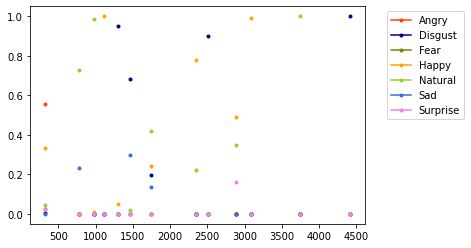

In [6]:
legend_list = ["Angry", "Disgust", "Fear", "Happy", "Natural", "Sad", "Surprise"]
linecolor = ["orangered", "navy", "olive", "orange", "yellowgreen", "royalblue", "violet"]
for start, end in  zip(eAn.voiceOnWave[:,0,1],eAn.voiceOnWave[:,1,1]):
    for i, name in zip(range(len(legend_list)),legend_list):
        plt.plot(time_axis[start:end], emotion[start:end,i], label=name,marker='.', color=linecolor[i])
    legend_list = ["", "", "", "", "", "", ""]
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### 保存用コマンド

In [7]:
dt_now = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
os.makedirs("output", exist_ok=True)
os.makedirs("output/"+str(dt_now), exist_ok=True)

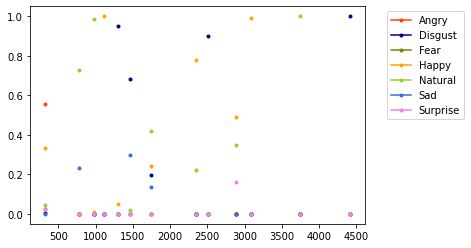

In [8]:
legend_list = ["Angry", "Disgust", "Fear", "Happy", "Natural", "Sad", "Surprise"]
linecolor = ["orangered", "navy", "olive", "orange", "yellowgreen", "royalblue", "violet"]
for start, end in  zip(eAn.voiceOnWave[:,0,1],eAn.voiceOnWave[:,1,1]):
    for i, name in zip(range(len(legend_list)),legend_list):
        plt.plot(time_axis[start:end], emotion[start:end,i], label=name,marker='.', color=linecolor[i])
    legend_list = ["", "", "", "", "", "", ""]
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
filename = "output/"+str(dt_now)+"/"+"graph.png"
plt.savefig(filename)

In [9]:
for no in eAn.voiceOnWave:
    Y=eAn.wave[no[0,0]:no[1,0]].reshape(-1)
    outd = struct.pack("h" * len(Y), *Y)
    filename = "output/"+str(dt_now)+ "/trimAt" + str(no[0,0])+"-"+str(no[1,0]) + ".wav"
    # 書き出し
    with wave.open(filename, 'w') as ww:
        ww.setnchannels(1)
        ww.setsampwidth(2)
        ww.setframerate(44100)
        ww.writeframes(outd)

In [10]:
Y=eAn.wave.reshape(-1)
outd = struct.pack("h" * len(Y), *Y)
filename = "output/"+str(dt_now)+ "/All.wav"
# 書き出し
with wave.open(filename, 'w') as ww:
    ww.setnchannels(1)
    ww.setsampwidth(2)
    ww.setframerate(44100)
    ww.writeframes(outd)